In [45]:
import matplotlib.pyplot as plt
import numpy as np

from mne import Epochs, pick_types, events_from_annotations, annotations_from_events
from mne.decoding import CSP

from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from data_parsing import Parser, Visualizer


<h1 style="color: #7ab3e6">Load the data, and filter the necessary channels or frequency:</h1>

In [2]:
parser = Parser(subject=1, runs=[6, 10, 14], mne_path="./mne_data")
parser.load_data()
montage = parser.select_montage('standard_1005')
noisy_channels = ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6',
                      'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']
parser.reduce_noise(60, noisy_channels)
picks = parser.reduce_noise()
parser.focus_and_clean(significant_frequencies=(8.0, 40.0))

Loading data for subject 1, at runs [6, 10, 14]

Selecting montage: standard_1005

Reducing noise:
Removing frequency 60
Removing bad or noisy channels: ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']

Reducing noise:
Removing bad or noisy channels: bads

Focussing on significant frequencies



<h3 style="color: #7ab3e6">Ok so what do we have excatly as data:</h3>

#### 1. Input: Amplitude Values

The floats in the numpy array returned by `raw.get_data()` correspond to the <span style="color: #7ab3e6">amplitude values of the EEG signal</span> recorded at different electrodes and at different time points.

<span style="color: #7ab3e6">Each row of the numpy array corresponds to a different electrode</span>, and <span style="color: #7ab3e6">each column corresponds to a different time point.</span> The amplitude values are typically measured in microvolts (µV) and represent the electrical activity of the brain recorded by the electrodes.

The specific meaning of the amplitude values will depend on the electrode placement and the EEG recording setup. For example, different electrodes may be sensitive to different frequencies of electrical activity in the brain, and the amplitude of the signal may be affected by various factors such as electrode impedance, amplifier gain, and filtering. Therefore, it is important to carefully consider the details of the EEG recording setup and the data processing pipeline when interpreting the raw EEG data.

In [14]:
data = parser.raw.get_data()
print(str(data)[:200])

[[ 1.60936260e-20  1.52094007e-07 -2.19056822e-06 ... -1.97260691e-07
  -8.64296975e-08 -8.47032947e-22]
 [ 1.77876919e-20  3.14773715e-06 -7.78848437e-06 ... -2.17462917e-07
  -9.14113859e-08  1.6940


In [16]:
print(f"Nombre d'electrodes differentes: {len(data)=}")
print(f"Nombre de differents time points: {len(data[0])=}")
print(f"Exemple of an amplitude value: {data[0][0]=}µV")

Nombre d'electrodes differentes: len(data)=42
Nombre de differents time points: len(data[0])=60000
Exemple of an amplitude value: data[0][0]=1.6093625997831706e-20µV



#### 2. Output: Actions

At certain time points, subject were ask to do (or think) of a certain action: rest, lift right hand, lift left hand...\
with `events, event_id = events_from_annotations(raw)` we get the type of events associated to each time point.\
for example: at the second 672, the subject was asked to do action 2 (lift right hand)...

In [48]:
parser.get_events(event_id=dict(T0=0, T1=1, T2=2))
print(f"{str(parser.events)[:100]}...")

Getting events from annotations

[[    0     0     0]
 [  672     0     2]
 [ 1328     0     0]
 [ 2000     0     1]
 [ 2656     0   ...


<h1 style="color:#7ab3e6">Format data for training:</h1>

We are doing to connect the inputs and the outputs of or model with the function `Epochs()`.


- Select the timing for training data (here from `1 to 2s`)
- Get your Input and Ouput data, split in train, test and eval:
    - epochs_data = all the inputs
    - epochs_data_train = inputs for training
    - labels = all the outputs

In [26]:
parser.get_events(event_id=dict(T1=1, T2=2))
tmin, tmax = -1.0, 4.0
epochs = Epochs(parser.raw, parser.events, parser.event_id, tmin, tmax, proj=True, baseline=None, preload=True)
epochs_data = epochs.get_data()
epochs_data_train = epochs.copy().crop(tmin=1., tmax=2.).get_data()
labels = epochs.events[:, -1]

Getting events from annotations



The reason why the code first selects a subpart of the data using epochs.copy().crop(tmin=1., tmax=2.).get_data() and then splits it using cross-validation is to ensure that the model is trained and evaluated on a standardized time window across all cross-validation folds.

In EEG analyses, it is common to focus on specific time windows of interest that are thought to correspond to cognitive or neural processes of interest (e.g., the P300 ERP component). By selecting a subpart of the data using crop(tmin=1., tmax=2.), the code is essentially selecting a time window of interest that starts at 1 second and ends at 2 seconds after each event, and discarding the rest of the data. This ensures that all data used for training and evaluation is restricted to the same time window, which can be important for obtaining reliable and interpretable results.

Once the data is cropped to the desired time window, the code uses cross-validation to split the data into training and validation sets multiple times, in order to estimate the generalization performance of the model. This allows the model to be evaluated on multiple different subsets of the data, which can help to ensure that the results are not overly dependent on the specific subset of data used for training and evaluation.

So, in summary, the code first selects a subpart of the data to focus on a specific time window of interest, and then uses cross-validation to train and evaluate the model on multiple different subsets of the data.

In [29]:
# _ = epochs.plot(scalings=dict(eeg=1e-4))

In [30]:
# epochs['T1'].plot_image(picks=[13])

In [31]:
# epochs['T2'].plot_image(picks=[13])

In [ ]:
def get_model_and_data(epochs, experiment_set=0, subject_number=1, from_scratch=False) -> float:
    labels = epochs.events[:, -1]
    epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data()
    cv = ShuffleSplit(10, test_size=0.2)
    if (from_scratch == True
        or os.path.exists(f'{SAVE_PATH}/models/experiment_{experiment_set}/S{subject_number:03d}.save') is False):
        # Assemble a classifier
        csp = CSP(n_components=6)
        lda = LinearDiscriminantAnalysis()
        clf = Pipeline([("CSP", csp), ("LDA", lda)])
        # fit our pipeline to the experiment
        X_train, X_test, y_train, y_test = train_test_split(epochs_train, labels, random_state=0)
        clf.fit(X_train, y_train)
        # save model
        joblib.dump(clf, f'{SAVE_PATH}/models/experiment_{experiment_set}/S{subject_number:03d}.save')
        print("Model was saved!") if from_scratch==True else 0
    else:
        # get model from models dir
        print("Model was gotten from save!") if from_scratch==True else 0
        clf = joblib.load(f'{SAVE_PATH}/models/experiment_{experiment_set}/S{subject_number:03d}.save')
    if from_scratch==True:
        scores = cross_val_score(clf, epochs_train, labels, cv=cv, n_jobs=None)
        print(f'cross_val_score: {np.mean(scores)}')

In [33]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

<h1 style="color:#7ab3e6">Choose algorithms:</h1>

<p style="color:#acc1e8">Dimenstionality reduction = CSP (Common spatial pattern)</p>

> Common spatial pattern (CSP) is a mathematical procedure used in signal processing for separating a multivariate signal into additive subcomponents which have maximum differences in variance between two windows

<p style="color:#acc1e8">Classification algorithm = LDA (Linear Discriminant Analysis)</p>

> LDA helps to find a linear combination of features that characterizes or separates two or more classes of objects or events



In [34]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

In [37]:
scores

array([0.88888889, 0.88888889, 0.88888889, 1.        , 1.        ,
       1.        , 0.88888889, 1.        , 0.77777778, 1.        ])

In [38]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
clf = Pipeline([('CSP', csp), ('LDA', lda)])

The cross_val_score function essentially does the following for each fold of the cross-validation:

Splits the data into training and validation sets based on the current fold indices.
Fits the estimator on the training set.
Evaluates the estimator on the validation set and computes a score (e.g., classification accuracy, AUC, etc.).
Returns the score for the current fold.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, random_state=0)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

In [40]:
predictions = clf.predict(X_test)

In [41]:
accuracy_score(predictions, y_test)

0.9166666666666666

In [42]:
scores

array([0.88888889, 0.88888889, 0.88888889, 1.        , 1.        ,
       1.        , 0.88888889, 1.        , 0.77777778, 1.        ])

Classification accuracy: 0.600000 / Chance level: 0.724138


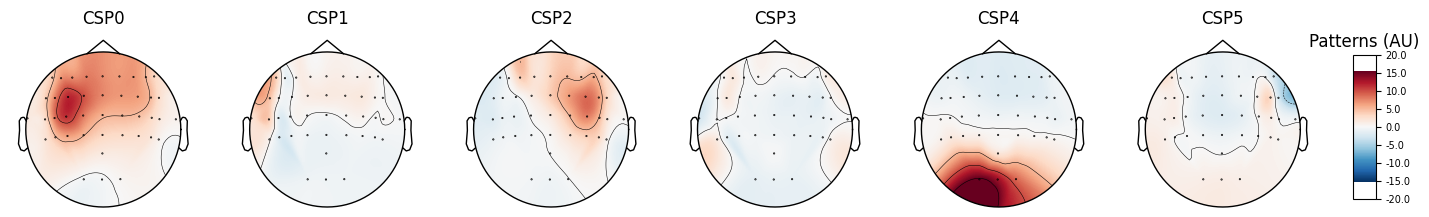

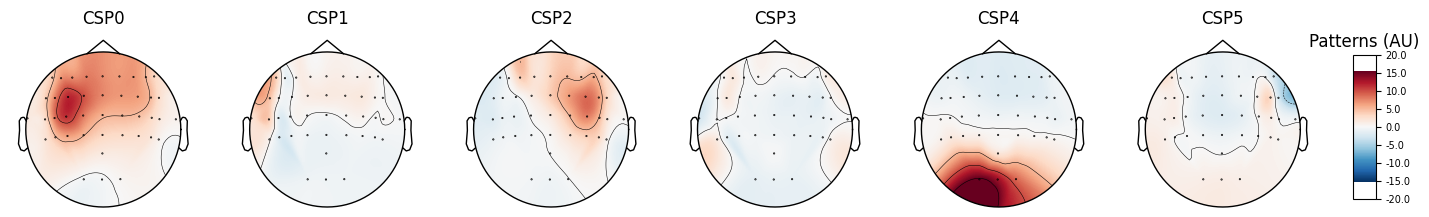

In [48]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [49]:
raw = parser.raw
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

i = 0
for train_idx, test_idx in cv_split:
    print(i)
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)
    i += 1

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin


0
1
2
3
4
5
6
7
8


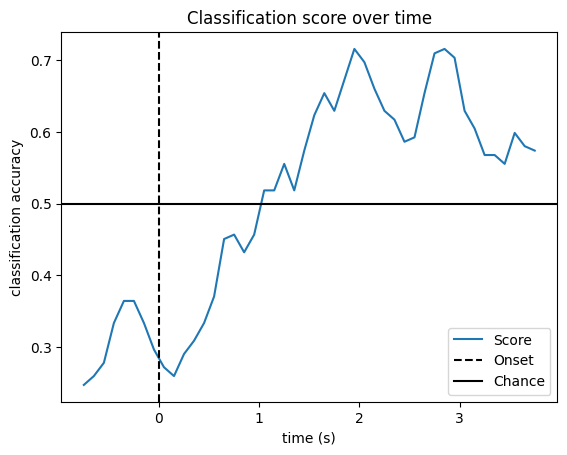

In [50]:
plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [54]:
import pandas as pd
from utils import tasks

In [50]:
df = pd.read_csv("./results/training_final.csv", index_col=False)
df['task_name'] = df['task_number'].map(lambda x: tasks[x]['name'])

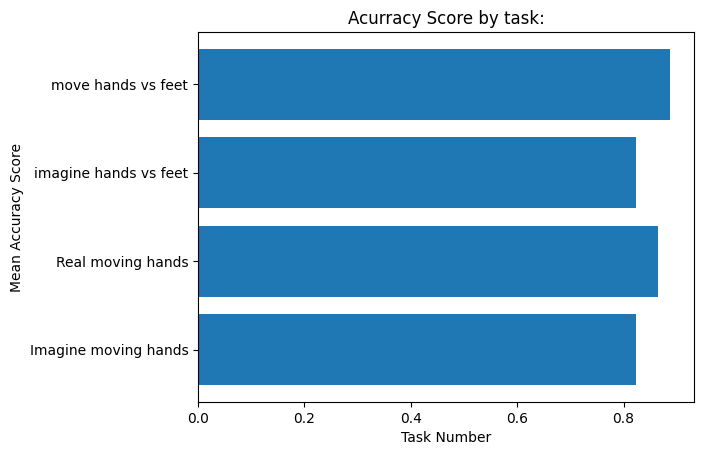

In [62]:
means = df.groupby(['task_name'])['training_score'].mean()
plt.barh(means.index, means)
plt.xlabel('Task Number')
plt.ylabel('Mean Accuracy Score')
plt.title("Acurracy Score by task:")
plt.show()

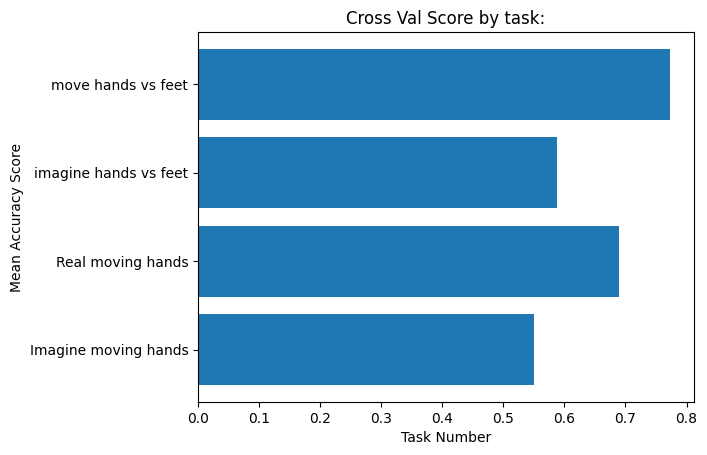

In [61]:
means = df.groupby(['task_name'])['cross_val_score'].mean()
plt.barh(means.index, means)
plt.xlabel('Task Number')
plt.ylabel('Mean Accuracy Score')
plt.title("Cross Val Score by task:")
plt.show()

In [68]:
for task in tasks:
    print(task)

{'name': 'Real moving hands', 'real': True, 'type': 'L vs R', 'runs': [3, 7, 11], 'labels': {0: 'rest', 1: 'left hand', 2: 'right hand'}, 'events': {'T0': 0, 'T1': 1, 'T2': 2}}
{'name': 'Imagine moving hands', 'real': False, 'type': 'L vs R', 'runs': [4, 8, 12], 'labels': {0: 'rest', 1: 'imagine left hand', 2: 'imagine right hand'}, 'events': {'T0': 0, 'T1': 1, 'T2': 2}}
{'name': 'move hands vs feet', 'real': True, 'type': 'Hands vs feet', 'runs': [5, 9, 13], 'labels': {0: 'rest', 1: 'hands', 2: 'feet'}, 'events': {'T0': 0, 'T1': 1, 'T2': 2}}
{'name': 'imagine hands vs feet', 'real': False, 'type': 'Hands vs feet', 'runs': [6, 10, 14], 'labels': {0: 'rest', 1: 'imagine both hands', 2: 'imagine both feet'}, 'events': {'T0': 0, 'T1': 1, 'T2': 2}}


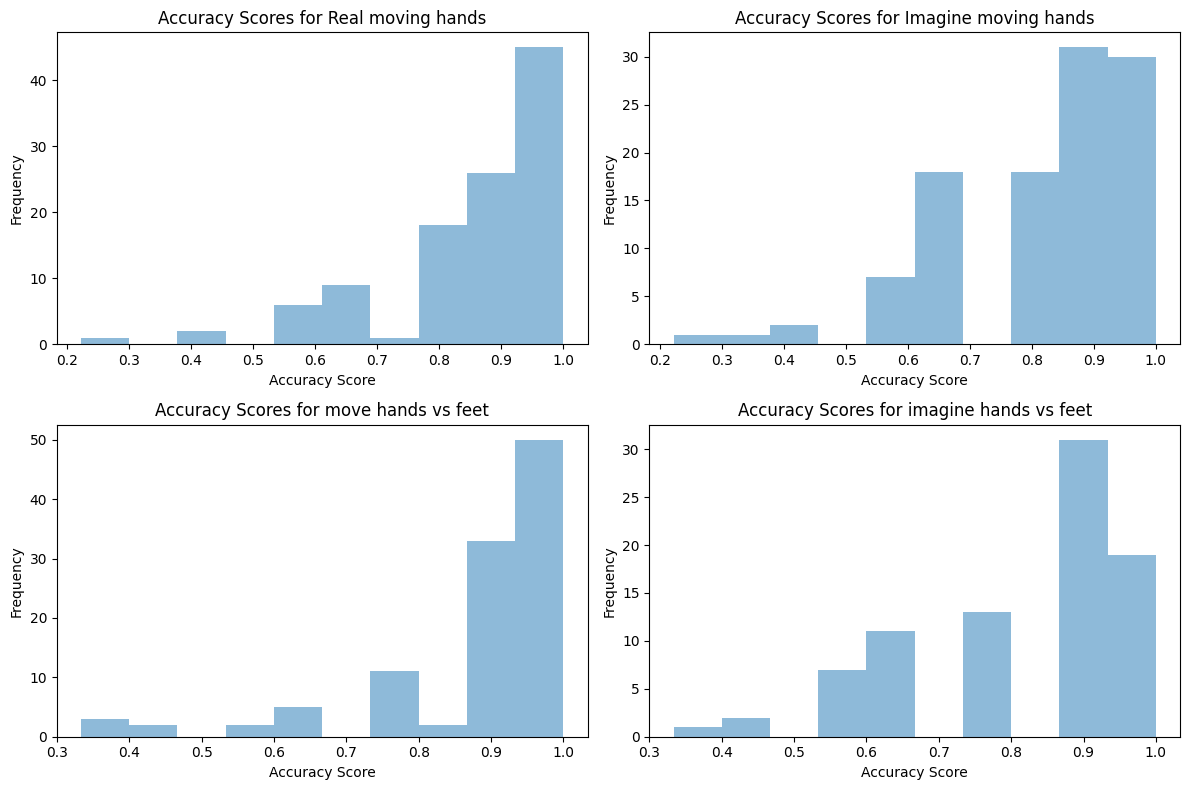

In [70]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the histogram of the training scores for each task on its corresponding subplot
for task, ax in zip(tasks, axs.flatten()):
    task_scores = df[df['task_name'] == task["name"]]['training_score']
    ax.hist(task_scores, alpha=0.5)
    ax.set_title(f'Accuracy Scores for {task["name"]}')
    ax.set_xlabel('Accuracy Score')
    ax.set_ylabel('Frequency')

# Adjust the layout of the subplots
plt.tight_layout()

plt.show()